In [1]:
# import libraries
import os
import pandas as pd
from pandas import DataFrame
import numpy as np
from sklearn.preprocessing import MinMaxScaler
#from sklearn.externals import joblib
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed

#tf.logging.set_verbosity(tf.logging.ERROR)
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, cohen_kappa_score, fbeta_score
from sklearn.metrics import recall_score, classification_report, auc, roc_curve, log_loss
LABELS = ["Normal","FMA"]

#set up graphic style in this case I am using the color scheme from xkcd.com
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8.7 # Golden Mean
col_list = ["cerulean","scarlet"]# https://xkcd.com/color/rgb/
sns.set(style='white', font_scale=1.75, palette=sns.xkcd_palette(col_list))

In [2]:
import time
import joblib

In [3]:
# set random seed
import tensorflow as tf
tf.random.set_seed(123)

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

### **Cargar training y testing**

In [5]:
# Cargar training y testing
# Read in data and display first 5 rows
test = pd.read_csv("Dataset_Test.csv")
# validation
train = pd.read_csv("Dataset_Training.csv")
print('The shape of our train is:', train.shape)
#test.head(5)
train.head(5)

The shape of our train is: (13508, 13)


,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
0,13.0,11.333333,10.0,0.0,128.000000,7.2,1022.328571,1020.8,1023.8,82.216667,4116.666667,15383.33333,0
1,14.0,11.200000,10.0,3.0,312.500000,6.2,1020.375000,1018.8,1021.9,84.546667,16217.333330,12080.00000,0
2,15.0,11.952381,8.0,0.0,297.368421,9.2,1020.085714,1019.1,1021.9,83.685714,18158.235290,10523.80952,0
3,16.0,11.571429,8.0,0.0,270.000000,5.1,1022.650000,1021.6,1024.1,82.300000,22000.000000,10400.00000,0
4,16.0,13.368421,10.0,0.0,196.250000,4.1,1025.137500,1024.0,1027.3,77.289474,22000.000000,10915.78947,0


## Seleccionar FMA en el test

In [6]:
train.describe()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
count,13508.000000,13508.000000,13508.000000,13508.000000,13508.000000,13508.000000,13508.000000,13508.000000,13508.000000,13508.000000,13508.000000,13508.000000,13508.000000
mean,19.676806,16.527427,13.418826,2.521661,259.908275,8.082220,1018.625722,1017.591343,1019.614051,73.678395,12728.824720,10760.395185,0.060187
std,4.536595,3.756481,3.137305,13.152030,71.750631,2.730977,4.108797,4.281946,4.143853,13.903987,7321.613235,1892.074017,0.237841
min,9.000000,8.142857,-0.500000,0.000000,20.400000,0.000000,916.900000,915.900000,916.900000,8.631250,15.000000,104.761905,0.000000
25%,16.000000,13.590909,11.000000,0.000000,196.096774,6.200000,1016.433333,1015.500000,1017.300000,70.571909,6398.759091,10095.178575,0.000000
50%,19.000000,16.153394,13.000000,0.000000,295.000000,8.200000,1018.500000,1017.600000,1019.400000,76.582353,13445.863970,11106.875000,0.000000
75%,22.000000,18.833824,15.000000,0.500000,316.666667,9.800000,1020.762500,1019.800000,1021.800000,81.838231,19700.000000,11787.741940,0.000000
max,41.300000,35.509091,30.000000,512.000000,360.000000,51.000000,1034.860000,1034.500000,1038.100000,99.761111,22000.000000,20985.454550,1.000000


In [7]:
train = train[train['FMA'] == 0] # Seleccion de datos

In [8]:
train.head()

,temp_max,temp_avg,temp_min,prec,wd,ws,atmos_pres_avg,atmos_pres_min,atmos_pres_max,rh,ceil_hgt,visibility,FMA
0,13.0,11.333333,10.0,0.0,128.000000,7.2,1022.328571,1020.8,1023.8,82.216667,4116.666667,15383.33333,0
1,14.0,11.200000,10.0,3.0,312.500000,6.2,1020.375000,1018.8,1021.9,84.546667,16217.333330,12080.00000,0
2,15.0,11.952381,8.0,0.0,297.368421,9.2,1020.085714,1019.1,1021.9,83.685714,18158.235290,10523.80952,0
3,16.0,11.571429,8.0,0.0,270.000000,5.1,1022.650000,1021.6,1024.1,82.300000,22000.000000,10400.00000,0
4,16.0,13.368421,10.0,0.0,196.250000,4.1,1025.137500,1024.0,1027.3,77.289474,22000.000000,10915.78947,0


In [9]:
split = 1460 # Validation
validation = train[-split:]
train = train[:-split]

In [10]:
# The last element contains the labels
# Convertir Series to DataFrame (.to_frame())
train_fma = train.iloc[:, -1]
validation_fma = validation.iloc[:, -1]
test_fma = test.iloc[:, -1]

# Columnas
train_fma.columns = ['train_fma']
validation_fma.columns = ['validation_fma']
test_fma.columns = ['test_fma']

In [11]:
test_fma.head()

0    0
1    0
2    0
3    0
4    0
Name: FMA, dtype: int64

https://www.tensorflow.org/guide/keras/train_and_evaluate#automatically_setting_apart_a_validation_holdout_set

### **Correlation**

In [12]:
# test.corr()

In [13]:
#train.corr()

In [14]:
#plt.matshow(train.corr())
#plt.show()

### **Actualizar Datos**

In [15]:
# Eliminar Campos
#test = test.drop(['temp_avg','temp_min', 'atmos_pres_min', 'wd', 'atmos_pres_max','atmos_pres_avg', 'rh','ceil_hgt', 'visibility', 'FMA'], axis=1) 
# ceil_hgt # visibility ,'temp_max','temp_min'
test = test.drop(['atmos_pres_min', 'atmos_pres_max','ceil_hgt', 'visibility', 'FMA'], axis=1)

In [16]:
# Eliminar Campos
#train = train.drop(['temp_avg','temp_min', 'atmos_pres_min', 'wd', 'atmos_pres_max','atmos_pres_avg', 'rh','ceil_hgt', 'visibility', 'FMA'], axis=1)
train = train.drop(['atmos_pres_min', 'atmos_pres_max','ceil_hgt', 'visibility', 'FMA'], axis=1)

In [17]:
# Eliminar Campos
#validation = validation.drop(['temp_avg','temp_min', 'atmos_pres_min', 'wd', 'atmos_pres_max','atmos_pres_avg', 'rh','ceil_hgt', 'visibility', 'FMA'], axis=1)
validation = validation.drop(['atmos_pres_min', 'atmos_pres_max','ceil_hgt', 'visibility', 'FMA'], axis=1)

In [18]:
# Descriptive statistics for each column
#test.describe()

In [19]:
print("Training dataset shape:", train.shape)
print("Test dataset shape:", validation.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (11235, 8)
Test dataset shape: (1460, 8)
Test dataset shape: (3261, 8)


In [20]:
#train.corr()

In [21]:
#test.corr()

In [22]:
#plt.matshow(train.corr())
#plt.show()

In [23]:
#fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
#ax.plot(train['temp_max'], label='temp_max',  color='blue', animated = False,
#        linestyle='None', marker='*', linewidth=0.5)
#ax.plot(train['temp_avg'], label='temp_avg', color='red', animated = True, linewidth=1)
#plt.legend(loc='lower left')
#ax.set_title('Testing de lectura de Variables', fontsize=16)
#plt.show()

In [24]:
#fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
#ax.plot(train['ws'], label='ws',  color='blue', animated = False,
#        linestyle='None', marker='.', linewidth=0.5)
#ax.plot(train['temp_avg'], label='temp_avg', color='red', animated = True, linewidth=1)
#plt.legend(loc='lower left')
#ax.set_title('Testing de lectura de Variables', fontsize=16)
#plt.show()

## Normalize the data or Standardize the data ?

In [25]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)
X_validation = scaler.transform(validation)
scaler_filename = "scaler_data"
joblib.dump(scaler, scaler_filename)

['scaler_data']

In [26]:
# reshape inputs for LSTM [samples, timesteps, features]
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]) # X_train 
print("Training data shape:", X_train.shape)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])     # X_test 
print("Test data shape:", X_test.shape)
X_validation = X_validation.reshape(X_validation.shape[0], 1, X_validation.shape[1])  #X_validation
print("Test data shape:", X_validation.shape)

Training data shape: (11235, 1, 8)
Test data shape: (3261, 1, 8)
Test data shape: (1460, 1, 8)


In [27]:
# define the autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(16, activation='relu',  #16
              kernel_regularizer=regularizers.l2(0.00))(inputs)
    output = (Dense(X.shape[2])) (L1)    
    model = Model(inputs=inputs, outputs=output)
    return model

In [28]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adamax', loss='mae', metrics=['mae', 'mse', 'mape', 'msle', 
                                                     'cosine_proximity']) #Error absoluto medio (mae), MeanSquaredError mse
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 8)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1600      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
Total params: 1,736
Trainable params: 1,736
Non-trainable params: 0
_________________________________________________________________


In [29]:
# collect data across multiple repeats
dtrain = DataFrame()
val = DataFrame()
# fit the model to the data
for i in range(1):
    print("Fit model on training data...")
    start = time.time()
    nb_epochs = 200 # 100
    batch_size = 32 # 10 # 32 casi por defecto...
    #history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_data=(X_test, X_test), shuffle=False,
    #                    verbose=0).history # we use 5% of the training data for validation 
    
    history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(X_validation, X_validation), verbose=0).history # we use 5% of the training data for validation 
                                                              # after each epoch (validation_split = 0.05)        
    end = time.time()
    # story history
    dtrain[str(i)] = history['loss']
    val[str(i)] = history['val_loss']
    print("Time to training model: ", end='')
    print(end - start)

Fit model on training data...
Time to training model: 420.4452590942383


In [30]:
#X_train.shape

In [31]:
# Grafo que evalua las distintas iteraciones
#print(dtrain.describe())
#dtrain.boxplot()
#plt.show()

In [32]:
# print the best MSE reached on the test set
print("Best MSE on Validation Set =", max(history['val_mae']))

Best MSE on Validation Set = 0.10352607071399689


In [33]:
#print("#########################################################")
loss = model.evaluate(X_train, X_train, verbose=0)
print(loss)

[0.09927185624837875, 0.09927213191986084, 0.023601001128554344, 102721.40625, 0.011101995594799519, 0.9679362773895264]


In [34]:
#print(model.metrics_names)

In [35]:
loss = model.evaluate(X_test, X_test, verbose=0)
#print(loss)

In [36]:
#print('loss', loss[0])
#print('mae', loss[1])
#print('mse', loss[2])
#print('mape', loss[3])
#print('msle', loss[4])
#print('cosine_proximity', loss[5])

In [37]:
# Mejor !!!
for name, value in zip(model.metrics_names, loss):
    print(name, value)

loss 0.11026771366596222
mae 0.11025287210941315
mse 0.051295146346092224
mape 46356.09765625
msle 0.015364565886557102
cosine_proximity 0.9589817523956299


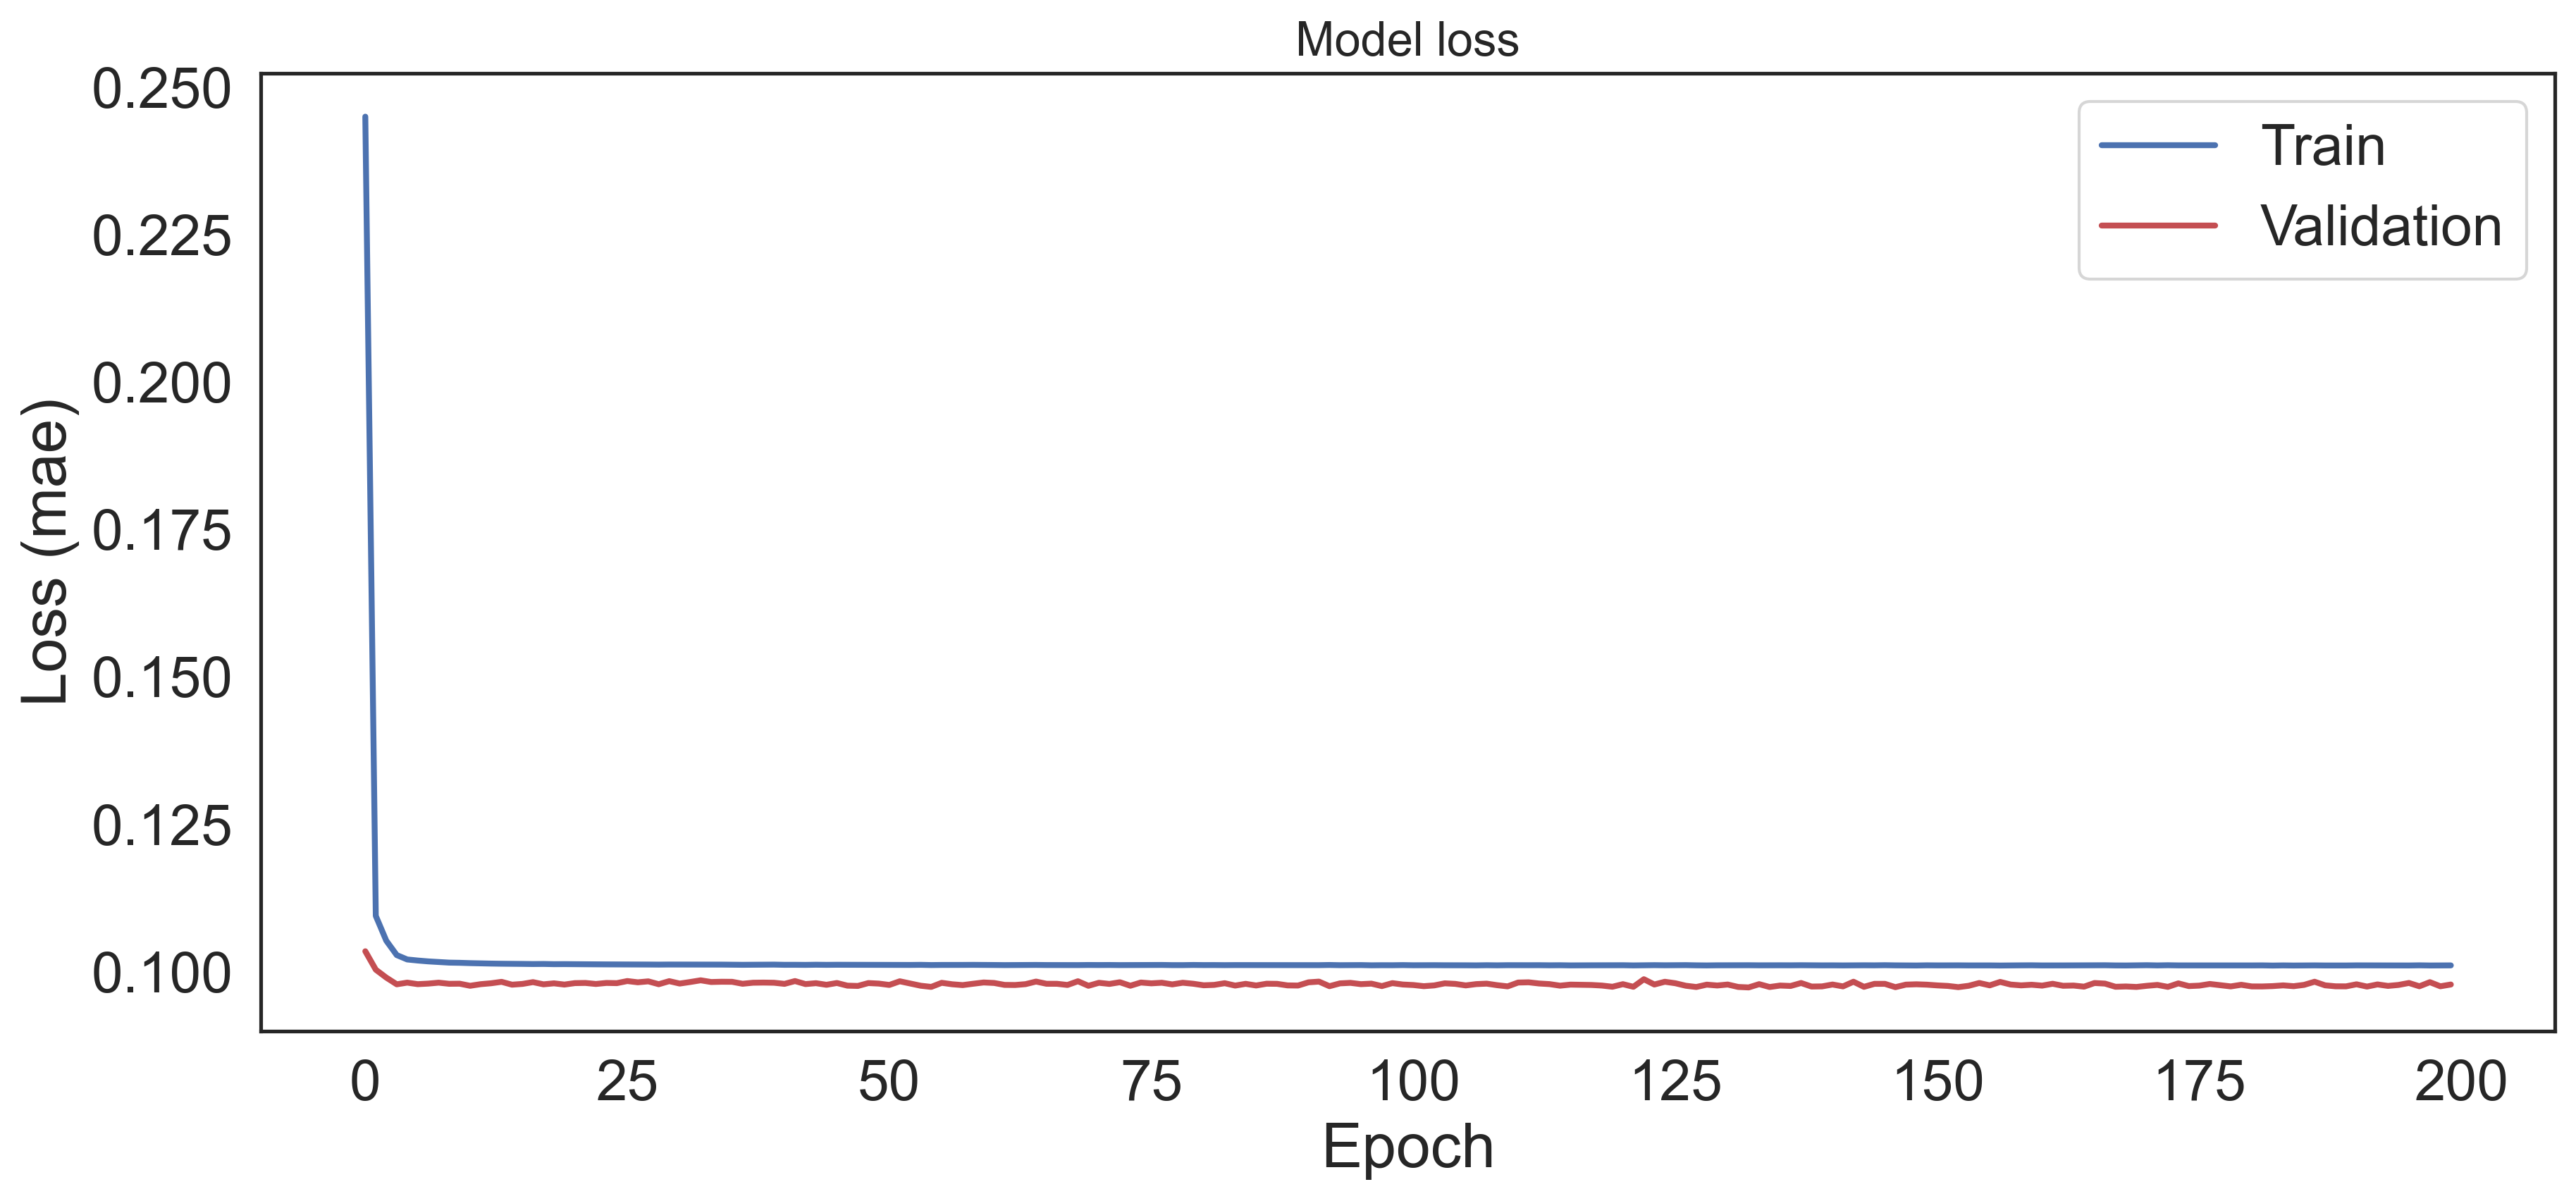

In [38]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)
ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

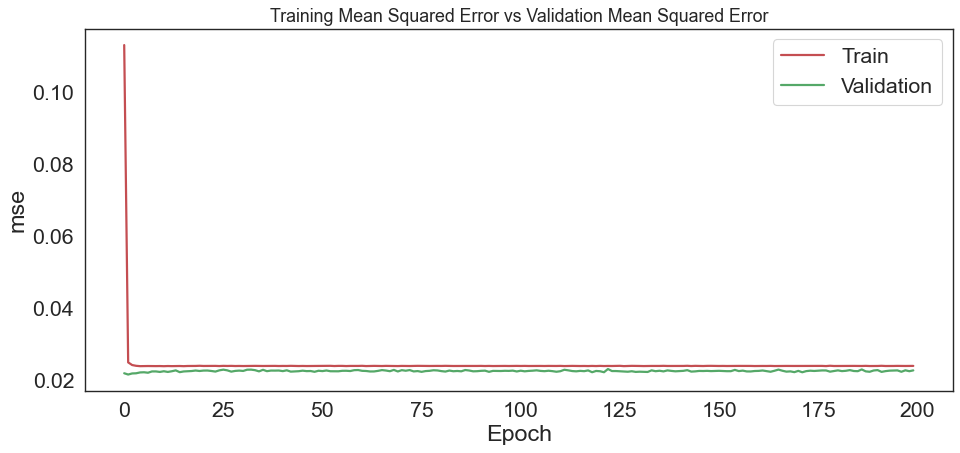

In [39]:
# plot the training losses
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history['mse'], 'r', label='Train', linewidth=2)
ax.plot(history['val_mse'], 'g', label='Validation', linewidth=2)
ax.set_title('Training Mean Squared Error vs Validation Mean Squared Error', fontsize=16)
ax.set_ylabel('mse')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

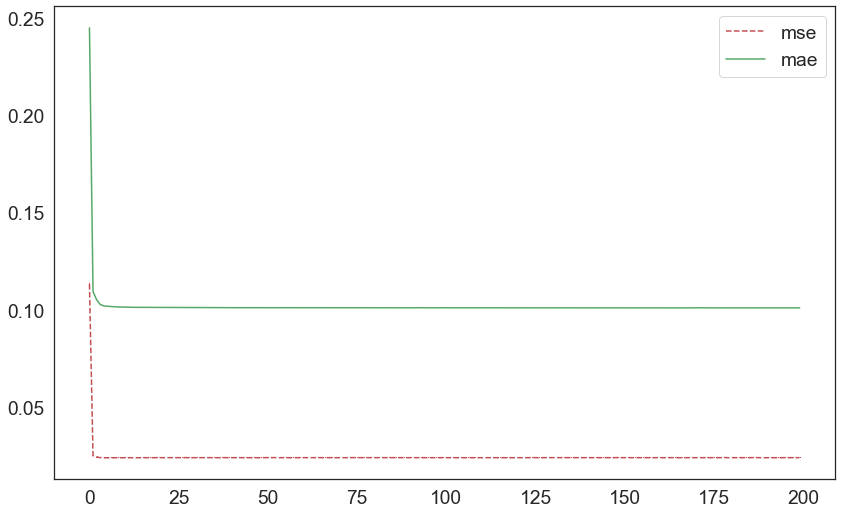

In [40]:
# plot metrics
plt.plot(history['mse'],'r--,', label='mse')
plt.plot(history['mae'],'g', label='mae')
# plt.plot(history['mape'],'y', label='mape')
# plt.plot(history['cosine_proximity'], 'b', label='cosine_proximity')
plt.legend(loc='upper right')
plt.show()

In [41]:
X_pred = model.predict(X_train)

In [42]:
X_pred.shape[1]

8

## Distribution of Loss Function

In [43]:
# plot the loss distribution of the training set
X_pred = model.predict(X_train)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

(0.0, 0.4)

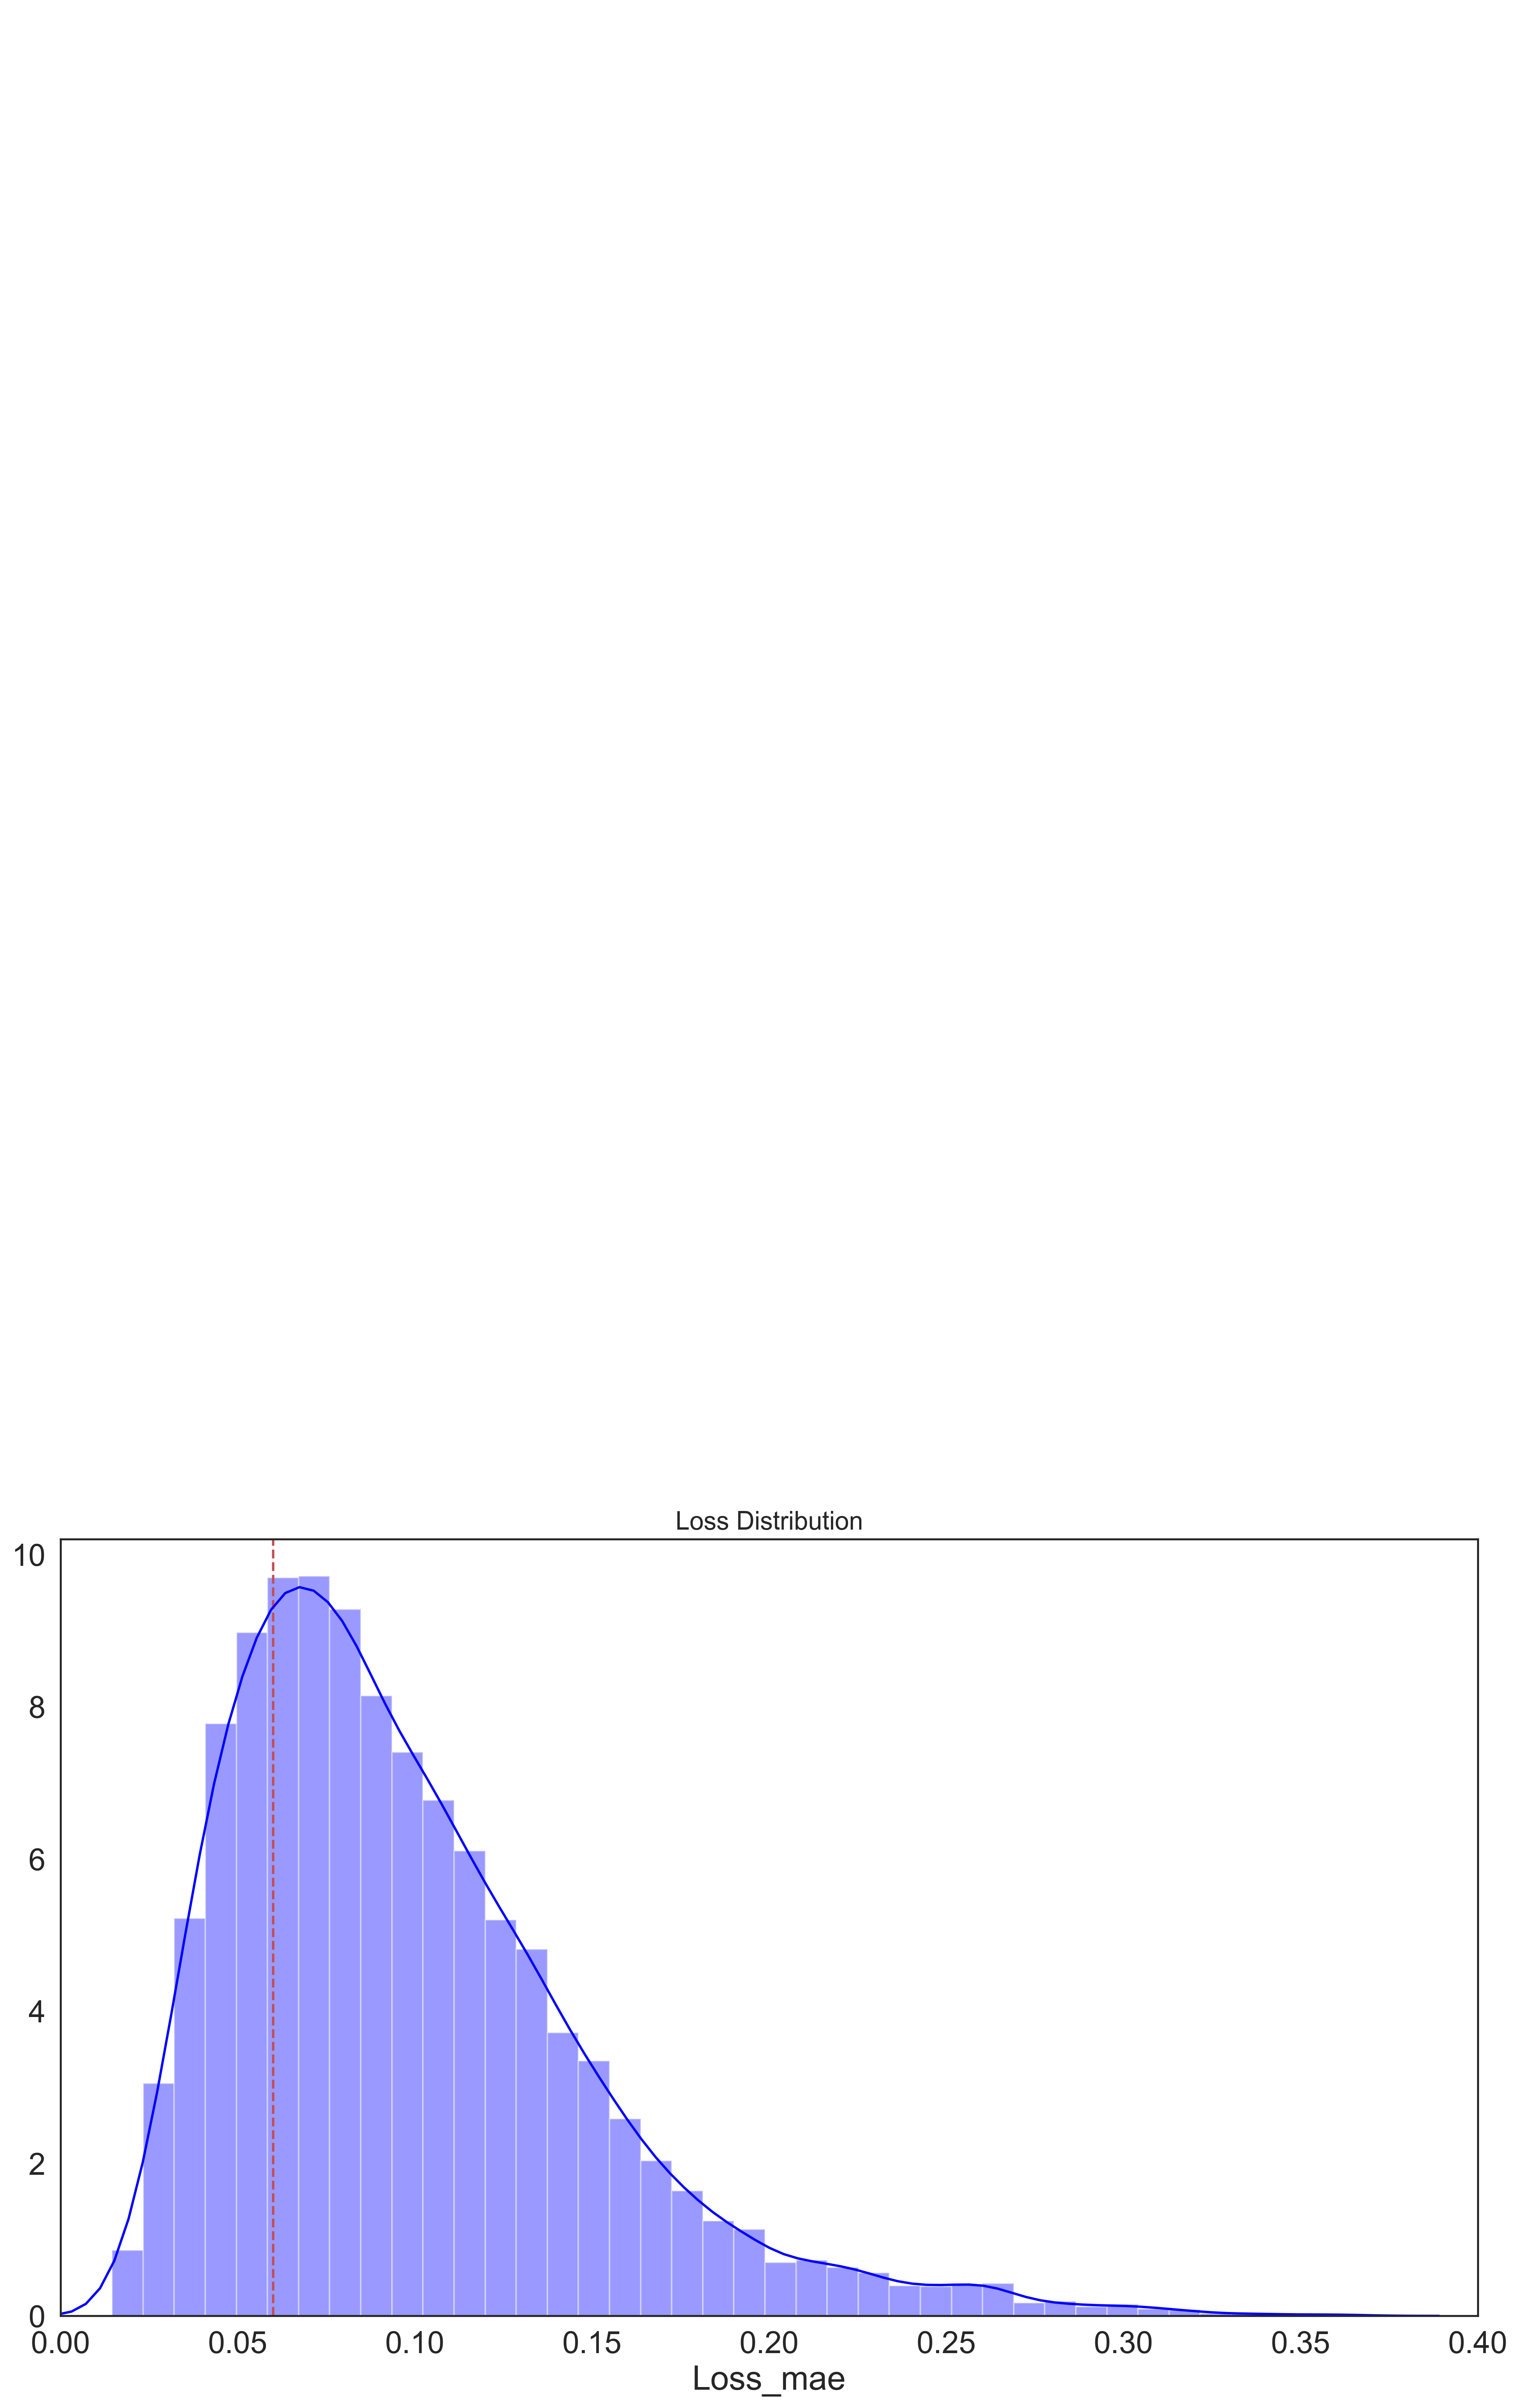

In [44]:
scored = pd.DataFrame(index=train.index)
Xtrain = X_train.reshape(X_train.shape[0], X_train.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi= 300)
plt.title('Loss Distribution', fontsize=16)
# Add a vertical line, here we set the style in the function call
plt.axvline(0.06, ls='--', color='r')
plt.annotate('Threshold = 0.06',
            xy=(0.06, 30), xycoords='data', fontsize=14,
            horizontalalignment='center', verticalalignment='bottom')
sns.distplot(scored['Loss_mae'], bins = 40, kde= True, color = 'blue');
plt.xlim([0.0,.4])

In [45]:
#X_train.shape

In [46]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

In [47]:
scored = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis = 1)
scored['Threshold'] = 0.1 # 0.275
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
#scored.head()

In [48]:
scored.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3261 entries, 0 to 3260
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Loss_mae   3261 non-null   float64
 1   Threshold  3261 non-null   float64
 2   Anomaly    3261 non-null   bool   
dtypes: bool(1), float64(2)
memory usage: 54.3 KB


In [49]:
#scored.to_csv('FMA.csv', sep=',')

In [50]:
data_filter = scored[scored['Anomaly'] == True]
#data_filter.head(1000)

In [51]:
#data_filter.info()

In [52]:
# Guardar los datos los FMA
#data_filter.to_csv('FMA.csv', sep=';')

In [53]:
# calculate the same metrics for the training set 
# and merge all data in a single dataframe for plotting
X_pred_train = model.predict(X_train)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[1])
X_pred_train = pd.DataFrame(X_pred_train, columns=train.columns)
X_pred_train.index = train.index

In [54]:
scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.1 #0.275
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

In [55]:
Xtrain.shape

(11235, 8)

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure.

<AxesSubplot:>

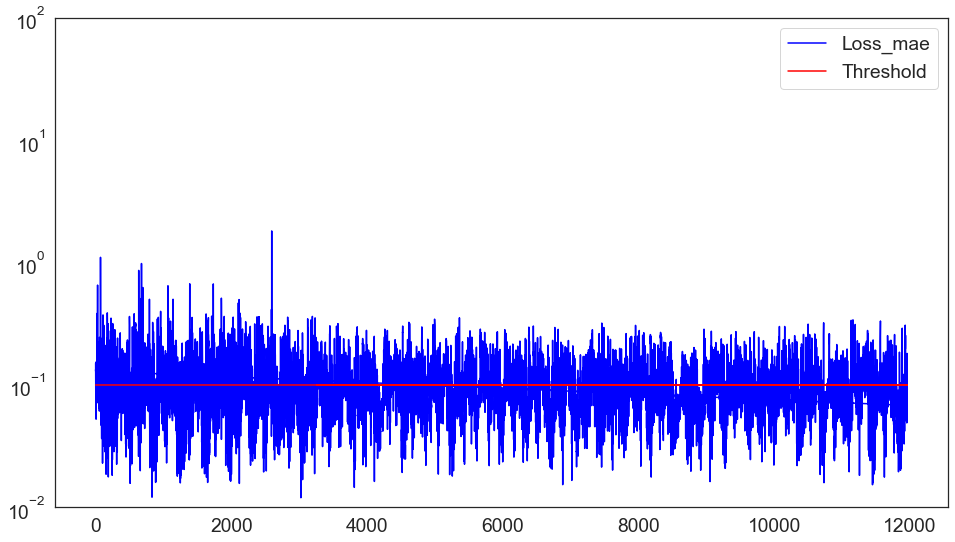

In [56]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize=(16,9), ylim=[1e-2,1e2], color=['blue','red'])

## Determinación de threshold con (max)

In [57]:
# Get train MAE loss.
x_train_pred = model.predict(X_train)

In [58]:
X_train.shape

(11235, 1, 8)

In [59]:
train_mae_loss = np.mean(np.abs(x_train_pred - Xtrain), axis=1)

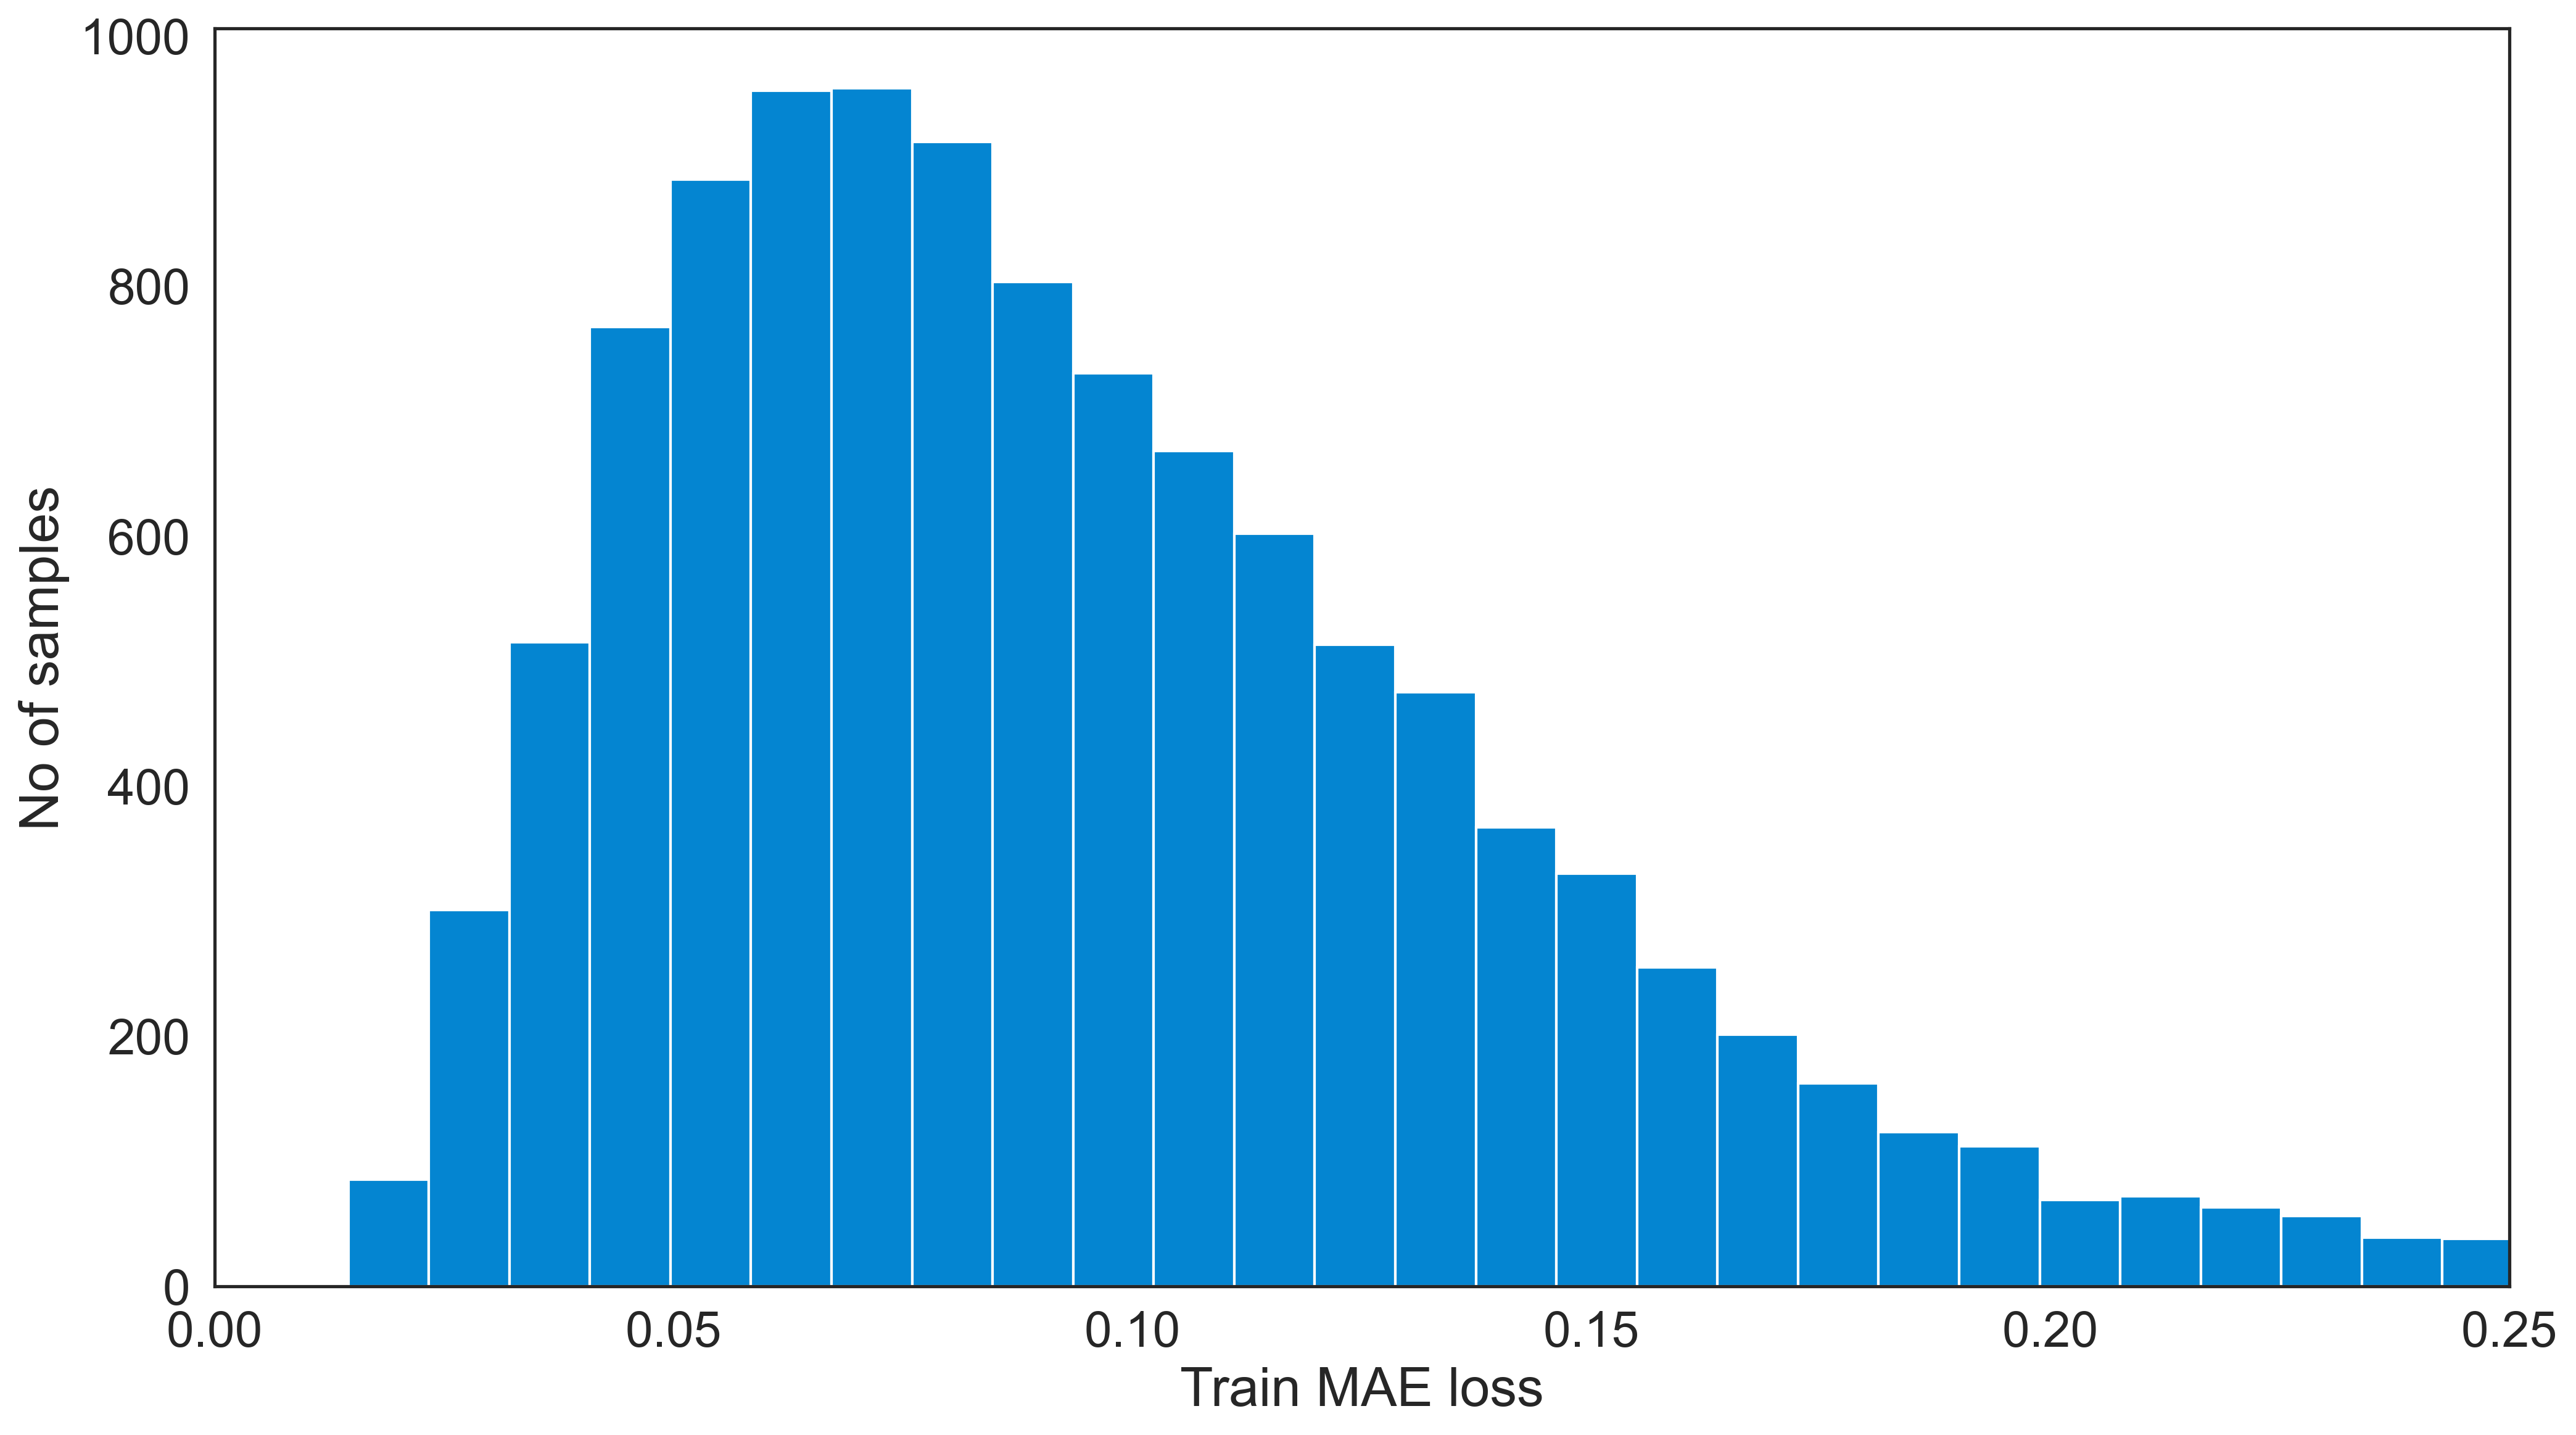

In [60]:
train_mae_loss = np.mean(np.abs(x_train_pred - Xtrain), axis=1)
plt.figure(figsize=(16,9), dpi= 300)
plt.hist(train_mae_loss, bins= 40)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.xlim([0.0,.25])
plt.show()

In [61]:
# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)


Reconstruction error threshold:  0.3655373503086885


In [62]:
#print("TF version:" + tf.__version__)
#print(tf.config.list_physical_devices('GPU'))

## Determinación de threshold con (mean + std)

In [63]:
# Forma tonta de hacer lo mismo
reconstructions = model.predict(X_train)
train_loss = np.mean(np.abs(reconstructions - Xtrain), axis=1)
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.1482541964211907


In [64]:
def print_stats(ytest, ypred):
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    ll = log_loss(ytest, ypred)
    print("Log Loss: {}".format(ll))
    print(' ')
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

# Version Dago .02
## Determinación de Clasificación. Test
## Análisis más aceptado!!!

In [65]:
threshold_fixed = 0.1 #0.1
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred, columns=test.columns)
X_pred.index = test.index

In [66]:
error_df = pd.DataFrame(index=test.index)
Xtest = X_test.reshape(X_test.shape[0], X_test.shape[2])
error_df['Reconstruction_error'] = np.mean(np.power(X_pred-Xtest, 2), axis = 1)
error_df['True_class'] = test_fma
error_df.head()

,Reconstruction_error,True_class
0,0.042244,0
1,0.035153,0
2,0.035159,0
3,0.022988,0
4,0.042861,0


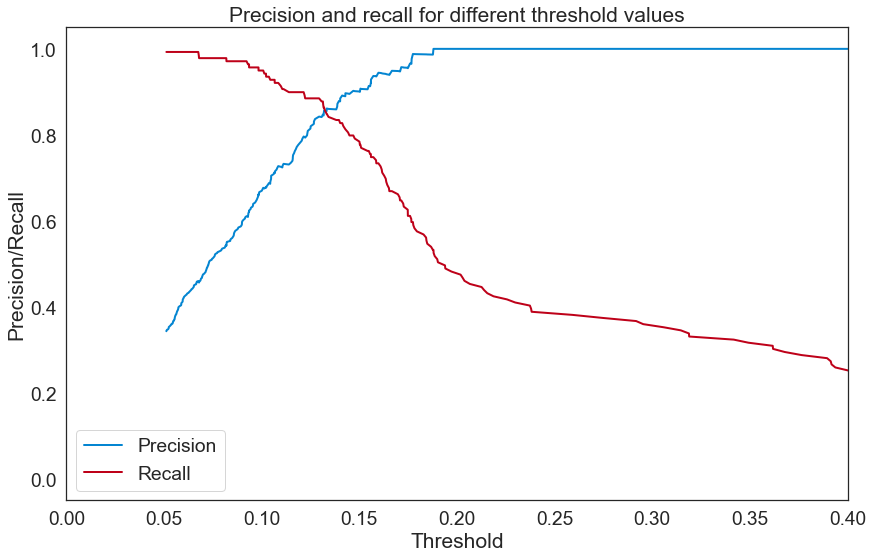

In [67]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=2)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=2)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.xlim([0.0,0.4]) # Permite gestionar la figura
plt.legend()
plt.show()

In [68]:
#print(threshold_rt)

## ROC Curve Check

Text(0.5, 0, 'False Positive Rate')

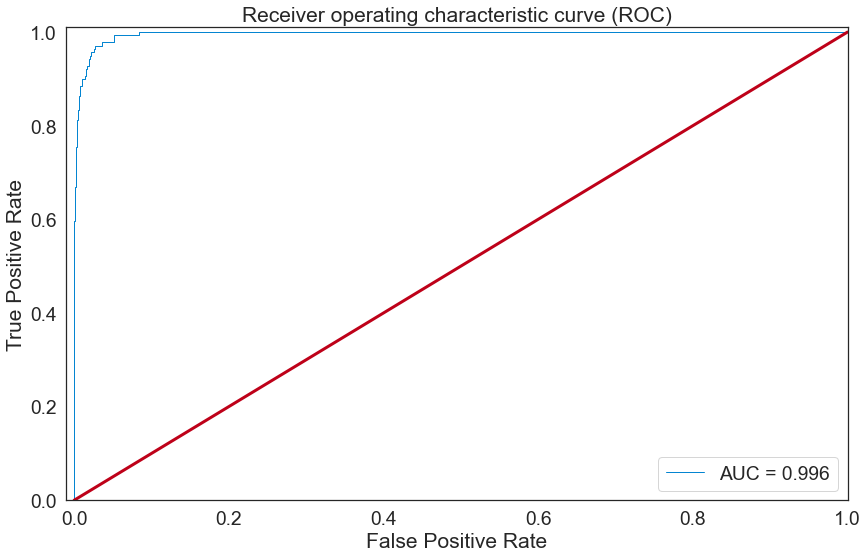

In [69]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth = 1, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth = 3)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

## Recall vs. Precision Thresholding

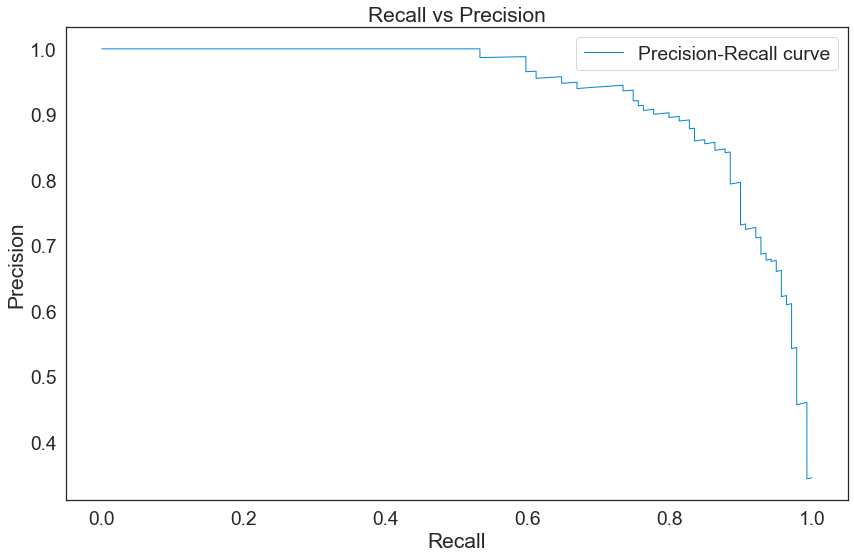

In [70]:
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(recall_rt, precision_rt, linewidth = 1, label='Precision-Recall curve')
plt.legend(loc='upper right')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Reconstruction Error vs Threshold Check. Importante threshold_fixed

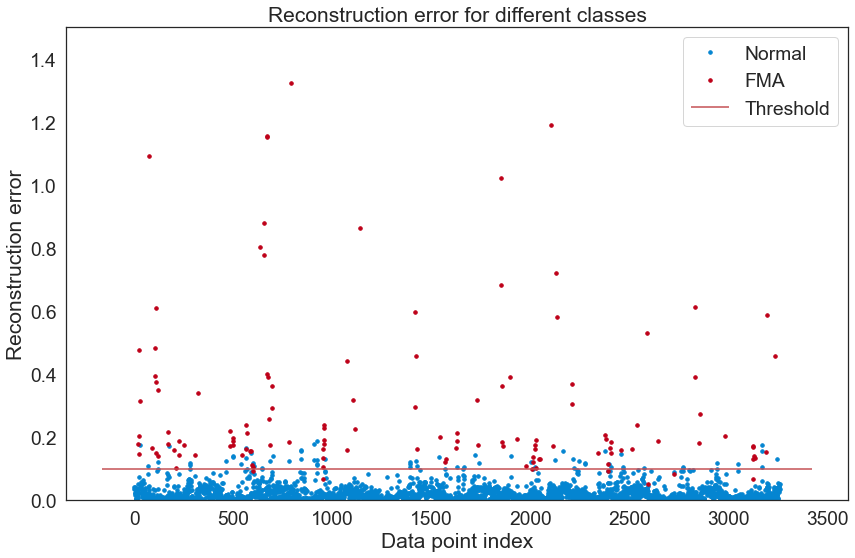

In [71]:
#threshold_fixed = 0.07 #0.1
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "FMA" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
plt.ylim([0, 1.5])
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show(); 

### Confusion Matrix

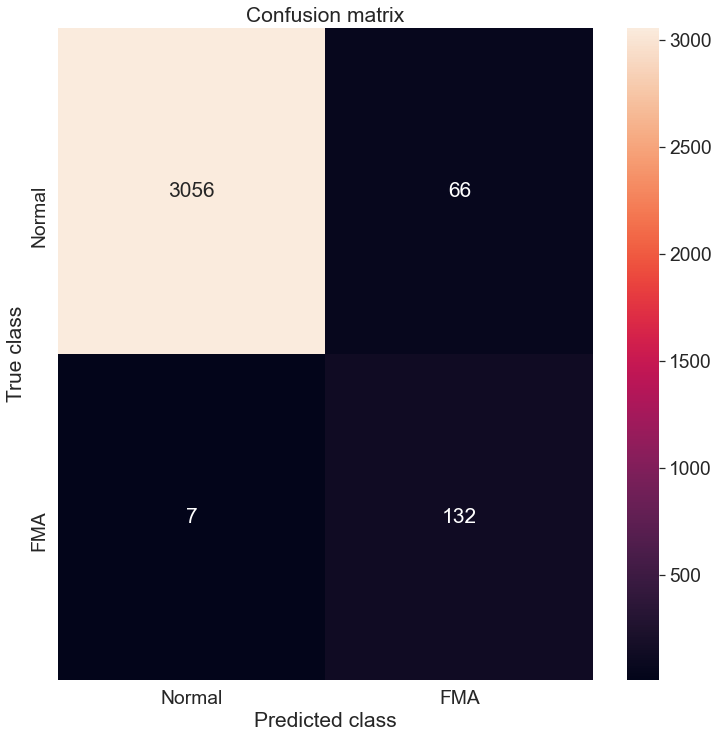

In [72]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [73]:
# Forma tonta de hacer lo mismo
reconstructions = model.predict(X_test)
test_loss = np.mean(np.abs(reconstructions - X_test), axis=1)
threshold = np.mean(test_loss) + np.std(test_loss)
print("Threshold: ", threshold)

Threshold:  0.31045364588474006


In [74]:
# error_df.True_class

In [75]:
print_stats(error_df.True_class, pred_y)

Accuracy: 0.97761, Cohen's Kappa Score: 0.77196
Log Loss: 0.7731933303461747
 
Confusion Matrix:
[[3056   66]
 [   7  132]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      3122
           1       0.67      0.95      0.78       139

    accuracy                           0.98      3261
   macro avg       0.83      0.96      0.89      3261
weighted avg       0.98      0.98      0.98      3261



In [76]:
p = precision_score(error_df.True_class, pred_y)
r = recall_score(error_df.True_class, pred_y)
f = fbeta_score(error_df.True_class, pred_y, beta= 0.5)
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

Result: p=0.667, r=0.950, f=0.709


## Reconstruction error - Test set

Text(0.5, 1.0, 'Reconstruction error - Test set')

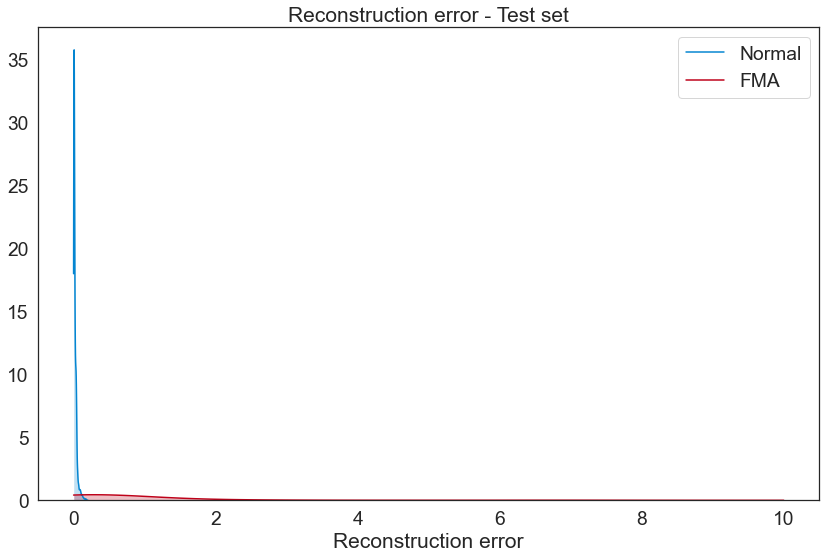

In [77]:
#plt.figure(figsize=(10,6))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==0], label='Normal', shade=True, clip=(0,10))
sns.kdeplot(error_df.Reconstruction_error[error_df.True_class==1], label='FMA', shade=True, clip=(0,10))
# Add a vertical line, here we set the style in the function call
#plt.axvline(0.01, ls='--', color='r')
#plt.annotate('Threshold = 0.01',
#            xy=(0.01, 250), xycoords='data', fontsize=14,
#            horizontalalignment='center', verticalalignment='bottom')
#plt.xlim([0, 0.2])
plt.xlabel('Reconstruction error');
plt.title('Reconstruction error - Test set')